# Study of the relation between Entropy of the predictive and optimum scaling temperature

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.extend(['..'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import entropy
import torch
import torch.nn as nn
from torch.nn.functional import softplus

from scipy_models import TS, HTS
from scipy_models import HistTS
from models import AdaTS
from models import HTS as HTS_torch
%aimport utils
from utils import compare_results, calib_split, torch_entropy, binByEntropy, load_precomputedlogits
%aimport adats_utils
from adats_utils import fitAdaTS

In [4]:
%matplotlib inline

In [5]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

In [6]:
color_palette_J = {
                     'black': '#000000',
                     'orange': '#E69F00',
                     'blue': '#56B4E9',
                     'green': '#009E73',
                     'orange': '#F0E442',
                     'dark_blue': '#0072B2',
                     'dark_orange': '#D55E00',
                     'pink': '#CC79A7',
                     'white': '#111111',
                     'grey': 'grey'
                   }


## Load data RESNET50

In [7]:
CIFAR10_PATH = '../../data/CIFAR10'
MODEL_PATH = '../../trained_models/CIFAR10/resnet50'

In [8]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [9]:
N, dim = Z_train.shape

#### Train standard Temp-Scaling

In [10]:
### Temp-Scal as baseline:
tempScaler = TS(dim)
tempScaler.fit(Z_val, y_val, v=True);

Optimization terminated successfully.
         Current function value: 2171.642972
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


#### Train Entropy Based Temp-Scaling

In [11]:
hts = HTS(dim)
hts.fit(Z_val, y_val, v=True)

         Current function value: 2152.374121
         Iterations: 11
         Function evaluations: 57
         Gradient evaluations: 51


In [12]:
hisTS = HistTS()
hisTS.fit(Z_val, y_val)

In [13]:
hts_t = AdaTS(HTS_torch(dim))
hts_t = fitAdaTS(hts_t, Z_val, y_val, epochs=30000, batch_size=10000, lr=1e-3, v=True)

On epoch: 7004, loss: 2.156e+03, at time: 43.42s
Finish training, convergence reached. Loss: 2156.17 



In [14]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScaler.predictive(Z_train),
                             'HTS': hts.predictive(Z_train),
                             'HTS_torch': hts_t.predictive(Z_train),
                             'Entropy Histogram TS': hisTS.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
           Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                         99.94%         0.11%        45.80%    1.104e-03     2.701e-03
TempScal                      99.94%         5.35%        65.23%    8.604e-03     5.812e-02
HTS                           99.94%         4.79%        74.31%    9.582e-03     5.312e-02
HTS_torch                     99.94%         4.69%        43.80%    8.502e-03     5.145e-02
Entropy Histogram TS          99.94%         4.82%        43.82%    1.043e-02     5.380e-02


In [15]:
print('##### Results on validation set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScaler.predictive(Z_val),
                             'HTS': hts.predictive(Z_val),
                             'HTS_torch': hts_t.predictive(Z_val),
                             'Entropy Histogram TS': hisTS.predictive(Z_val)}, target=y_val, from_logits=False);

##### Results on validation set:
           Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                         86.72%        10.30%        73.80%    2.300e-01     7.737e-01
TempScal                      86.72%         2.49%        55.51%    1.967e-01     4.343e-01
HTS                           86.72%         1.29%        80.79%    1.953e-01     4.305e-01
HTS_torch                     86.72%         1.79%        80.24%    1.959e-01     4.312e-01
Entropy Histogram TS          86.72%         1.27%        31.97%    1.949e-01     4.290e-01


In [16]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'HTS': hts.predictive(Z_test),
                             'HTS_torch': hts_t.predictive(Z_test),
                             'Entropy Histogram TS': hisTS.predictive(Z_test)}, target=y_test, from_logits=False);

##### Results on test set:
           Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                         86.13%        10.69%        35.80%    2.392e-01     7.897e-01
TempScal                      86.13%         2.35%        16.93%    2.037e-01     4.473e-01
HTS                           86.13%         0.96%        15.98%    2.024e-01     4.448e-01
HTS_torch                     86.13%         1.56%        22.38%    2.030e-01     4.449e-01
Entropy Histogram TS          86.13%         0.91%        22.35%    2.022e-01     4.451e-01


In [17]:
hts.b

3.070982955626601

In [18]:
hts.w

0.08824054990272831

In [19]:
hts_t.modelT.b

Parameter containing:
tensor([2.7807], requires_grad=True)

In [20]:
hts_t.modelT.w

Parameter containing:
tensor([0.0510], requires_grad=True)

## Fitted map $f(H) \mapsto T$

In [21]:
minH = 0
maxH = 1

x_axis = np.geomspace(minH+1e-8, maxH, 250)

In [22]:
lhb, lhw = hts.b, hts.w
lhb_t, lhw_t = hts_t.modelT.b.item(), hts_t.modelT.w.item()

def HTS2T(h):
    T = np.log(np.exp(np.log(h) * lhw + lhb) + 1)
    return T

def HTS2T_t(h):
    T = np.log(np.exp(np.log(h) * lhw_t + lhb_t) + 1)
    return T

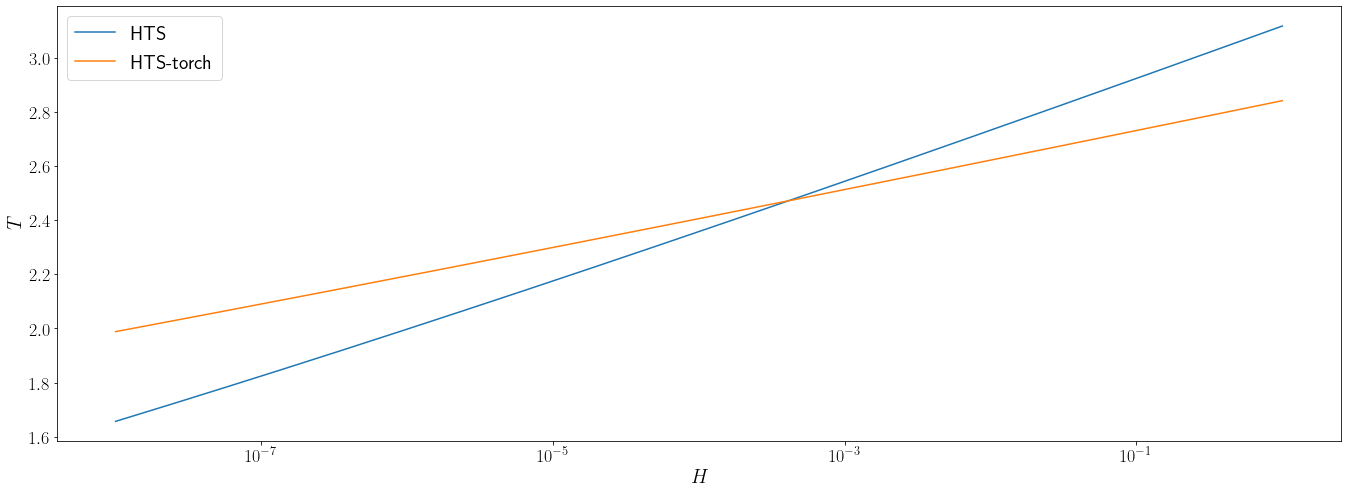

In [24]:
fig, ax = plt.subplots(figsize=(23, 8))

ax.plot(x_axis, HTS2T(x_axis), label='HTS')
ax.plot(x_axis, HTS2T_t(x_axis), label='HTS-torch')
ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();

### Estimate Optimum Temp vs Entropy

In [39]:
# Binarize Data
M = 10
ixs, lims = binByEntropy(Z_test, M=M, mode='log')

## Compute optimum entropy per bin
Ts = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TS(dim)
            ts_aux.fit(Z_test[ix], y_test[ix], v=False);
            Ts[i] = ts_aux.t
        except Exception as e:
            print(e)
            continue

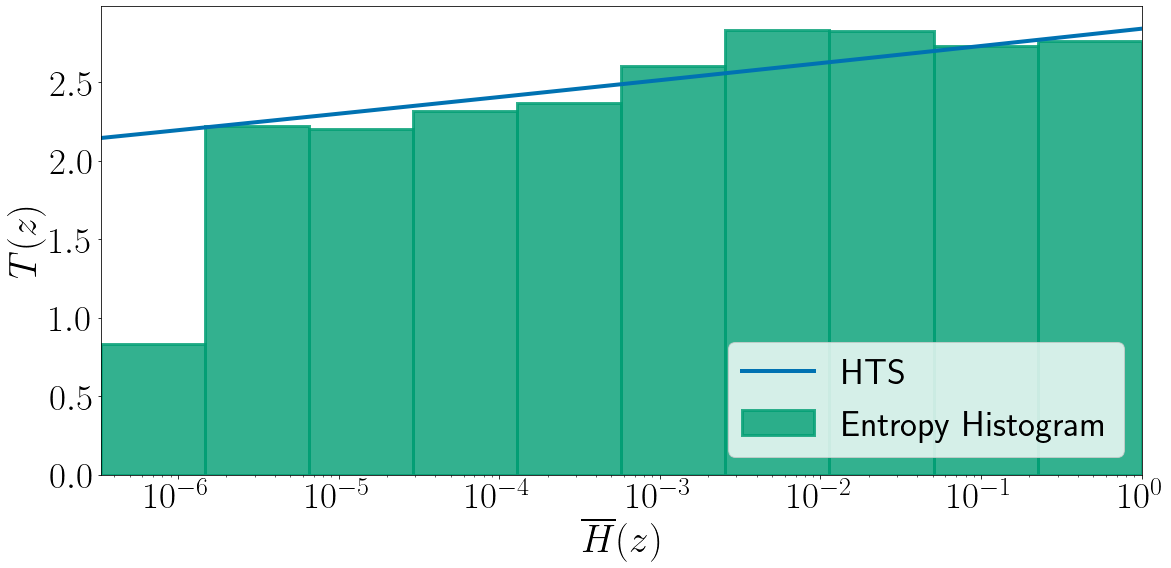

In [58]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(x_axis, HTS2T_t(x_axis), c=color_palette_J['dark_blue'], lw=4, label='HTS')
ax.bar(lims[:-1], Ts, width=(lims[1:]-lims[:-1]), align='edge', color=color_palette_J['green'], alpha=0.8, edgecolor=color_palette_J['green'], linewidth=3, label='Entropy Histogram')
ax.set_xlabel('$\overline{H}(z)$', fontsize=39)
ax.set_ylabel('$T(z)$', fontsize=39)

ax.tick_params(axis='both', labelsize=37)
ax.set_xscale('log')
ax.legend(fontsize=36, loc='lower right')
ax.set_xlim(lims[0], 1)

plt.tight_layout()
plt.plot();

fig.savefig('C:/Users/sergi/Google Drive/PhD/AdaTS/imgsPaper/HTS_entropy.png', dpi=600)

In [36]:
# Binarize Data
M = 10
ixs, lims = binByEntropy(Z_train, M=M, mode='log')

## Compute optimum entropy per bin
Ts = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TS(dim)
            ts_aux.fit(Z_train[ix], y_train[ix], v=False);
            Ts[i] = ts_aux.t
        except Exception as e:
            print(e)
            continue

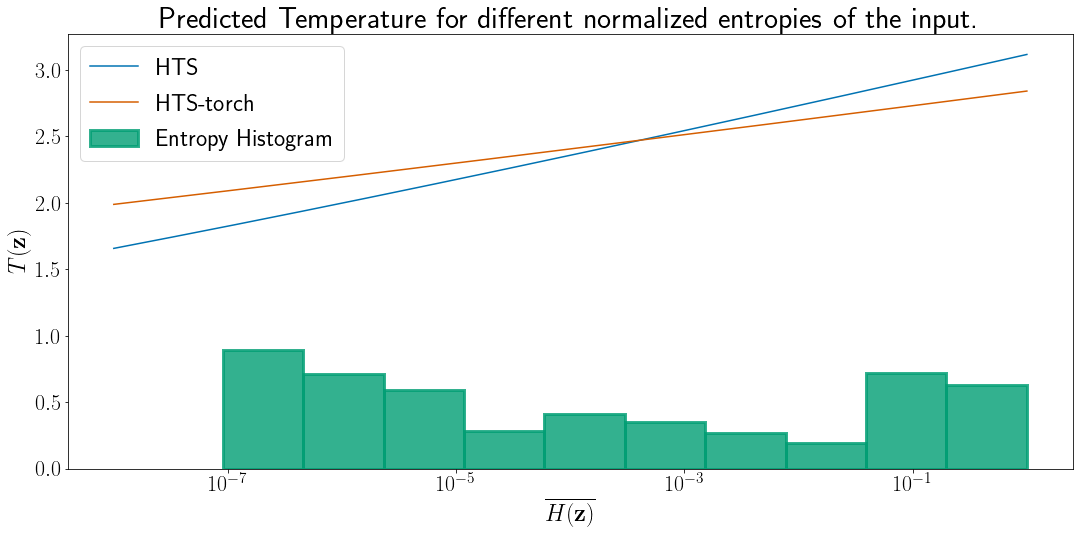

In [37]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(x_axis, HTS2T(x_axis), c=color_palette_J['dark_blue'], label='HTS')
ax.plot(x_axis, HTS2T_t(x_axis), c=color_palette_J['dark_orange'], label='HTS-torch')
ax.bar(lims[:-1], Ts, width=(lims[1:]-lims[:-1]), align='edge', color=color_palette_J['green'], alpha=0.8, edgecolor=color_palette_J['green'], linewidth=3, label='Entropy Histogram')
ax.set_xlabel('$\overline{H(\mathbf{z})}$', fontsize=24)
ax.set_ylabel('$T(\mathbf{z})$', fontsize=24)
ax.set_title('Predicted Temperature for different normalized entropies of the input.', fontsize=30)

ax.tick_params(axis='both', labelsize=22)
ax.set_xscale('log')
ax.legend(fontsize=24)

plt.plot();

## Comparison with LENET5: A better calibrated DNN

In [21]:
MODEL_PATH = '../../trained_models/CIFAR10/lenet5'

In [22]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [23]:
N, dim = Z_train.shape

In [24]:
### Temp-Scal as baseline:
tempScalerLN5 = TempScaling()
tempScalerLN5.fit(Z_val, y_val, v=True);

haTempScalerLN5 = AdaTS(HbasedT(dim))
haTempScalerLN5 = fitAdaTS(haTempScalerLN5, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-3, v=True)

lhaTempScalerLN5 = AdaTS(HlogbasedT(dim))
lhaTempScalerLN5 = fitAdaTS(lhaTempScalerLN5, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-3, v=True)

hisTSLN5 = HistTS()
hisTSLN5.fit(Z_val, y_val)

In [25]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScalerLN5.predictive(Z_train),
                             'EntropyAdaptiveTempScal': haTempScalerLN5.predictive(Z_train),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerLN5.predictive(Z_train),
                             'Entropy Histogram TS': hisTSLN5.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                69.24%         1.38%         2.42%    4.158e-01     8.638e-01
TempScal                             69.24%         2.72%         4.05%    4.166e-01     8.667e-01
EntropyAdaptiveTempScal              69.24%         2.84%         4.49%    4.168e-01     8.667e-01
log-EntropyAdaptiveTempScal          69.24%         2.85%         4.41%    4.168e-01     8.667e-01
Entropy Histogram TS                 48.23%         2.90%         7.22%    5.438e-01     1.344e+00


In [26]:
print('##### Results on val set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScalerLN5.predictive(Z_val),
                             'EntropyAdaptiveTempScal': haTempScalerLN5.predictive(Z_val),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerLN5.predictive(Z_val),
                             'Entropy Histogram TS': hisTSLN5.predictive(Z_val)}, target=y_val, from_logits=False);

##### Results on val set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                66.98%         2.17%        30.74%    4.444e-01     9.427e-01
TempScal                             66.98%         2.23%        40.90%    4.442e-01     9.417e-01
EntropyAdaptiveTempScal              66.98%         1.54%        23.97%    4.441e-01     9.413e-01
log-EntropyAdaptiveTempScal          66.98%         1.52%        31.05%    4.442e-01     9.414e-01
Entropy Histogram TS                 47.52%         3.00%         8.06%    5.534e-01     1.363e+00


In [27]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScalerLN5.predictive(Z_test),
                             'EntropyAdaptiveTempScal': haTempScalerLN5.predictive(Z_test),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerLN5.predictive(Z_test),
                             'Entropy Histogram TS': hisTSLN5.predictive(Z_test)}, target=y_test, from_logits=False);

##### Results on test set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                65.72%         1.61%        18.08%    4.636e-01     9.825e-01
TempScal                             65.72%         0.88%        18.18%    4.632e-01     9.805e-01
EntropyAdaptiveTempScal              65.72%         1.17%        12.63%    4.632e-01     9.803e-01
log-EntropyAdaptiveTempScal          65.72%         1.00%        18.04%    4.632e-01     9.803e-01
Entropy Histogram TS                 45.55%         2.14%         4.09%    5.758e-01     1.414e+00


In [28]:
bLN5, wLN5, tLN5 = haTempScalerLN5.modelT.b.item(), haTempScalerLN5.modelT.w.item(), haTempScalerLN5.modelT.t.item()
lbLN5, lwLN5= lhaTempScalerLN5.modelT.b.item(), lhaTempScalerLN5.modelT.w.item()

def HtoTLN5(h):
    T = (np.tanh(h * wLN5 + bLN5) + 1) * tLN5
    return T

def logHtoTLN5(h):
    T = np.log(np.exp(np.log(h) * lwLN5 + lbLN5) + 1)
    return T

In [29]:
# Binarize Data
M = 15
ixs, limsLN5 = binByEntropy(Z_val, M=M, mode='same')

## Compute optimum entropy per bin
TsLN5 = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TempScaling()
            ts_aux.fit(Z_val[ix], y_val[ix], v=True);
            TsLN5[i] = ts_aux.T.detach().numpy()
        except Exception as e:
            continue

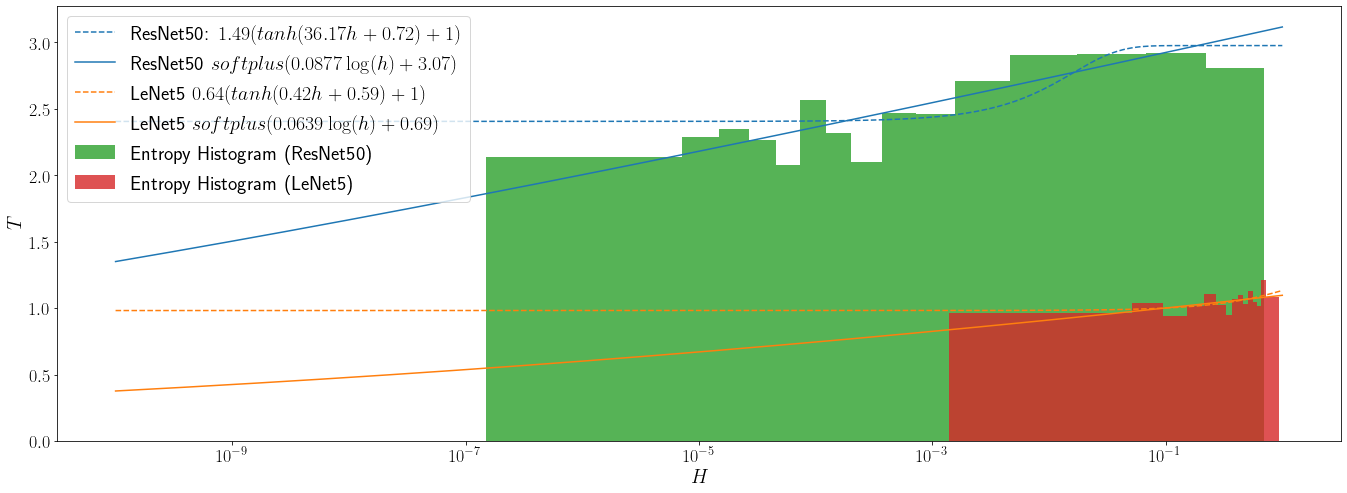

In [30]:
fig, ax = plt.subplots(figsize=(23, 8))

ax.plot(x_axis, HtoT(x_axis), ls='--', c='tab:blue', label='ResNet50: ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(t, w, b))
ax.plot(x_axis, logHtoT(x_axis), ls='-', c='tab:blue', label='ResNet50 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lw, lb))
ax.plot(x_axis, HtoTLN5(x_axis), ls='--', c='tab:orange', label='LeNet5 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tLN5, wLN5, bLN5))
ax.plot(x_axis, logHtoTLN5(x_axis), ls='-', c='tab:orange', label='LeNet5 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwLN5, lbLN5))
ax.bar(lims[:-1], Ts, width=lims[1:]-lims[:-1], align='edge', color='tab:green', alpha=0.8, label='Entropy Histogram (ResNet50)')
ax.bar(limsLN5[:-1], TsLN5, width=limsLN5[1:]-limsLN5[:-1], align='edge', color='tab:red', alpha=0.8, label='Entropy Histogram (LeNet5)')
ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();

## Comparison with Wide Resnet-28x10: A better calibrated DNN

In [31]:
DATASET = 'cifar10'


trainWR, validationWR, testWR = load_precomputedlogits(dataset=DATASET, model='wide-resnet-28x10', data_path='../../data')

Z_train, y_train = trainWR
Z_val, y_val = validationWR
Z_test, y_test = testWR

In [32]:
### Temp-Scal as baseline:
tempScalerWR = TempScaling()
tempScalerWR.fit(Z_val, y_val, v=True);

haTempScalerWR = AdaTS(HbasedT(dim))
haTempScalerWR = fitAdaTS(haTempScalerWR, Z_val, y_val, epochs=50000, batch_size=1000, lr=1e-4, v=True)

lhaTempScalerWR = AdaTS(HlogbasedT(dim))
lhaTempScalerWR = fitAdaTS(lhaTempScalerWR, Z_val, y_val, epochs=50000, batch_size=1000, lr=1e-4, v=True)

hisTSWR = HistTS()
hisTSWR.fit(Z_val, y_val, M=10)

In [33]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScalerWR.predictive(Z_train),
                             'EntropyAdaptiveTempScal': haTempScalerWR.predictive(Z_train),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerWR.predictive(Z_train),
                             'Entropy Histogram TS': hisTSWR.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                               100.00%         0.11%        14.28%    1.173e-05     1.102e-03
TempScal                            100.00%         0.89%        22.74%    2.116e-04     9.016e-03
EntropyAdaptiveTempScal             100.00%         0.63%        28.42%    1.895e-04     6.337e-03
log-EntropyAdaptiveTempScal         100.00%         0.70%        28.67%    2.036e-04     7.128e-03
Entropy Histogram TS                100.00%         0.88%        28.45%    3.241e-04     8.931e-03


In [34]:
print('##### Results on val set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScalerWR.predictive(Z_val),
                             'EntropyAdaptiveTempScal': haTempScalerWR.predictive(Z_val),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerWR.predictive(Z_val),
                             'Entropy Histogram TS': hisTSWR.predictive(Z_val)}, target=y_val, from_logits=False, M=50);

##### Results on val set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                95.36%         2.62%        44.71%    7.124e-02     1.562e-01
TempScal                             95.36%         1.65%        37.23%    6.758e-02     1.416e-01
EntropyAdaptiveTempScal              95.36%         1.13%        36.92%    6.691e-02     1.405e-01
log-EntropyAdaptiveTempScal          95.36%         1.23%        37.10%    6.706e-02     1.408e-01
Entropy Histogram TS                 94.58%         1.26%        47.78%    7.163e-02     1.635e-01


In [35]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScalerWR.predictive(Z_test),
                             'EntropyAdaptiveTempScal': haTempScalerWR.predictive(Z_test),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerWR.predictive(Z_test),
                             'Entropy Histogram TS': hisTSWR.predictive(Z_test)}, target=y_test, from_logits=False, M=50);

##### Results on test set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                96.13%         1.93%        70.70%    6.289e-02     1.497e-01
TempScal                             96.13%         0.70%        74.81%    6.080e-02     1.362e-01
EntropyAdaptiveTempScal              96.13%         0.92%        39.75%    6.070e-02     1.368e-01
log-EntropyAdaptiveTempScal          96.13%         0.73%        39.93%    6.070e-02     1.367e-01
Entropy Histogram TS                 95.30%         0.64%        25.85%    6.599e-02     1.608e-01


In [36]:
bWR, wWR, tWR = haTempScalerWR.modelT.b.item(), haTempScalerWR.modelT.w.item(), haTempScalerWR.modelT.t.item()
lbWR, lwWR= lhaTempScalerWR.modelT.b.item(), lhaTempScalerWR.modelT.w.item()

def HtoTWR(h):
    T = (np.tanh(h * wWR + bWR) + 1) * tWR
    return T

def logHtoTWR(h):
    T = np.log(np.exp(np.log(h) * lwWR + lbWR) + 1)
    return T

In [37]:
# Binarize Data
M = 10
ixs, limsWR = binByEntropy(Z_val, M=M, mode='same')

## Compute optimum entropy per bin
TsWR = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TempScaling()
            ts_aux.fit(Z_val[ix], y_val[ix], v=True);
            TsWR[i] = ts_aux.T.detach().numpy()
        except Exception as e:
            continue

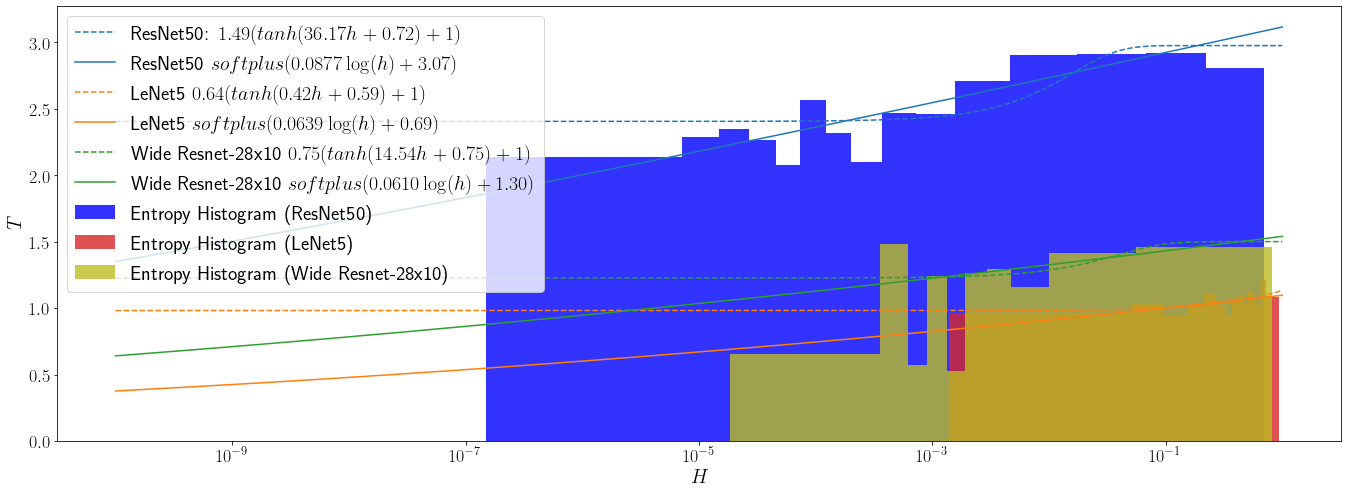

In [38]:
fig, ax = plt.subplots(figsize=(23, 8))

ax.plot(x_axis, HtoT(x_axis), ls='--', c='tab:blue', label='ResNet50: ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(t, w, b))
ax.plot(x_axis, logHtoT(x_axis), ls='-', c='tab:blue', label='ResNet50 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lw, lb))
ax.bar(lims[:-1], Ts, width=lims[1:]-lims[:-1], align='edge', color='blue', alpha=0.8, label='Entropy Histogram (ResNet50)')

ax.plot(x_axis, HtoTLN5(x_axis), ls='--', c='tab:orange', label='LeNet5 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tLN5, wLN5, bLN5))
ax.plot(x_axis, logHtoTLN5(x_axis), ls='-', c='tab:orange', label='LeNet5 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwLN5, lbLN5))
ax.bar(limsLN5[:-1], TsLN5, width=limsLN5[1:]-limsLN5[:-1], align='edge', color='tab:red', alpha=0.8, label='Entropy Histogram (LeNet5)')

ax.plot(x_axis, HtoTWR(x_axis), ls='--', c='tab:green', label='Wide Resnet-28x10 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tWR, wWR, bWR))
ax.plot(x_axis, logHtoTWR(x_axis), ls='-', c='tab:green', label='Wide Resnet-28x10 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwWR, lbWR))
ax.bar(limsWR[:-1], TsWR, width=limsWR[1:]-limsWR[:-1], align='edge', color='tab:olive', alpha=0.8, label='Entropy Histogram (Wide Resnet-28x10)')

ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();

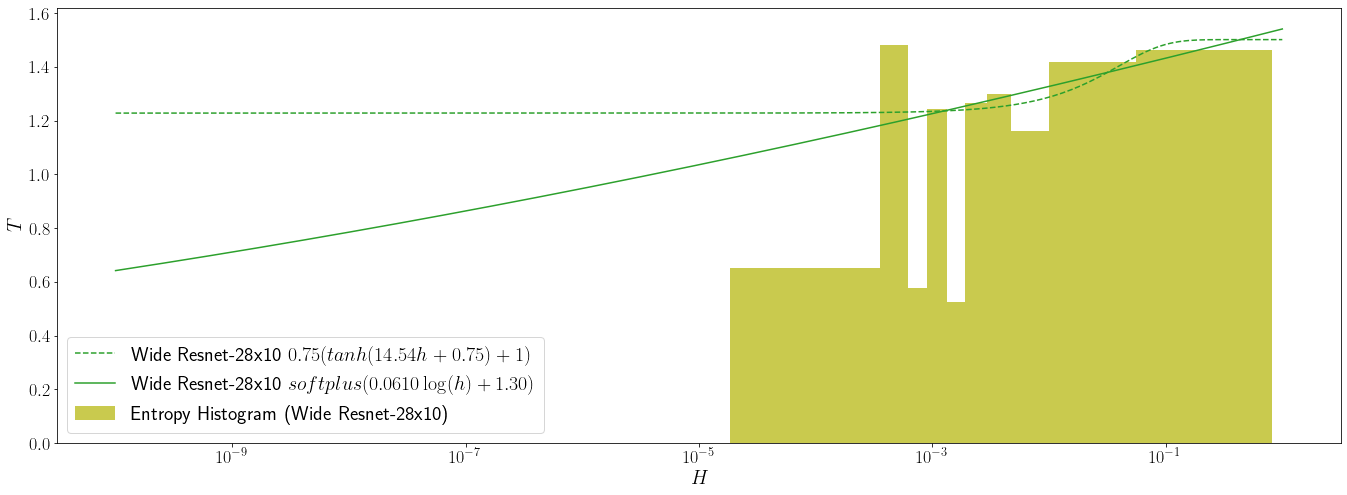

In [39]:
fig, ax = plt.subplots(figsize=(23, 8))


ax.plot(x_axis, HtoTWR(x_axis), ls='--', c='tab:green', label='Wide Resnet-28x10 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tWR, wWR, bWR))
ax.plot(x_axis, logHtoTWR(x_axis), ls='-', c='tab:green', label='Wide Resnet-28x10 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwWR, lbWR))
ax.bar(limsWR[:-1], TsWR, width=limsWR[1:]-limsWR[:-1], align='edge', color='tab:olive', alpha=0.8, label='Entropy Histogram (Wide Resnet-28x10)')

ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();